## **Importing Libararies:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils import shuffle 

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout, Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## **Loading Data:**

In [2]:
train_labels = pd.read_csv(r'../input/arabic-hwr-ai-pro-intake1/train.csv')
train_im = np.array([cv2.imread(file) for file in sorted(glob.glob(r"../input/arabic-hwr-ai-pro-intake1/train/*.png"))]).astype("float32")/255

test_labels = pd.read_csv(r'../input/arabic-hwr-ai-pro-intake1/test.csv')
test_im = np.array([cv2.imread(file) for file in sorted(glob.glob(r"../input/arabic-hwr-ai-pro-intake1/test/*.png"))]).astype("float32")/255

print(f"Training set size: {len(train_labels)}, Images per letter: {len(train_labels[train_labels['label'] == 1])}")
print(f"Testing set size : {len(test_labels)}")
print(f"Image Shape: {train_im[0].shape}")

Training set size: 13440, Images per letter: 480
Testing set size : 3360
Image Shape: (32, 32, 3)


### Data Visualisation:

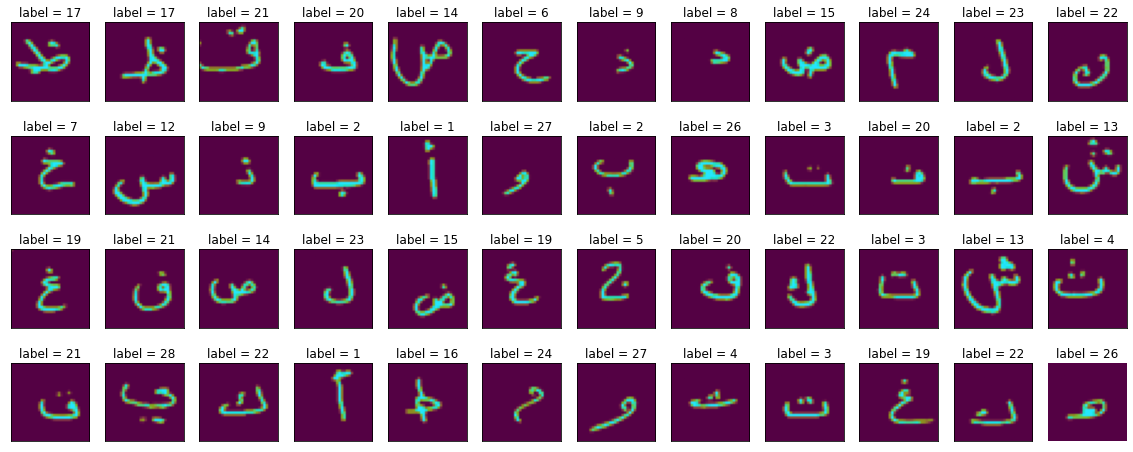

In [3]:
fig, ax = plt.subplots(4, 12, figsize=(20, 8))
np.random.seed(42)
random_indices = list(np.random.randint(0, 13439, 48))

for i, ax in zip(random_indices, ax.flatten()):
    ax.imshow(train_im[i,...])
    ax.set_title(f'label = {train_labels.iloc[i]["label"]}')
    ax.set(xticks=[], yticks=[])
    plt.axis("off")
    

## **Preprocessing:**

In [4]:
train_y = to_categorical(train_labels["label"] - 1, num_classes=28).astype(int)
train_y.shape

(13440, 28)

In [5]:
#Shuffle the data:
X_train, y_train = shuffle(train_im, train_y,random_state = 42)

## **Building Neural Network Model:**

In [6]:
model = Sequential([
                    Input(shape=X_train[0].shape, name="Input"),
                    
                    Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="uniform", name="Conv_1"),
                    MaxPooling2D(pool_size=(2,2),name="Pool_1"),
                    BatchNormalization(name="BN_1"),

                    Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="uniform", name="Conv_2"),
                    MaxPooling2D(pool_size=(2,2),name="Pool_2"),
                    Dropout(0.2, name="Dropout_1"),
                    BatchNormalization(name="BN_2"),

                    Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="uniform", name="Conv_3"),
                    MaxPooling2D(pool_size=(2,2),name="Pool_3"),
                    Dropout(0.2, name="Dropout_2"),
                    BatchNormalization(name="BN_3"),

                    Flatten(),
    
                    Dense(128, activation="relu",  kernel_initializer="uniform", name="Dense_1"),
    
                    Dense(64, activation="relu",  kernel_initializer="uniform", name="Dense_2"),
    
                    Dense(32, activation='relu',  kernel_initializer="uniform", name="Dense_3"),
                    BatchNormalization(name="BN_4"),
                    Dropout(0.2, name="Dropout_3"),
    
                    Dense(28, activation='softmax', name="Dense_4")
                   ]
#                    ,name="Initial_Model"
)

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2021-11-07 20:25:46.352252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:46.466174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:46.466867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:46.468194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 16, 16, 32)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 16, 16, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 8, 8, 64)          0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 8, 8, 64)          2

node zero
2021-11-07 20:25:46.470560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:46.471567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:48.314522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:48.315332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:25:48.315975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [7]:
early_stopping_cb = EarlyStopping(patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping_cb, checkpoint]) 

2021-11-07 20:25:49.087118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-07 20:25:50.572683: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


168/168 [==============================] - 8s 7ms/step - loss: 2.2847 - accuracy: 0.3540 - val_loss: 3.4448 - val_accuracy: 0.0361

Epoch 00001: val_loss improved from inf to 3.44478, saving model to weights.hdf5
Epoch 2/200
168/168 [==============================] - 1s 6ms/step - loss: 0.9769 - accuracy: 0.7542 - val_loss: 5.0732 - val_accuracy: 0.0361

Epoch 00002: val_loss did not improve from 3.44478
Epoch 3/200
168/168 [==============================] - 1s 5ms/step - loss: 0.4888 - accuracy: 0.8836 - val_loss: 5.4902 - val_accuracy: 0.1001

Epoch 00003: val_loss did not improve from 3.44478
Epoch 4/200
168/168 [==============================] - 1s 5ms/step - loss: 0.3202 - accuracy: 0.9181 - val_loss: 2.9583 - val_accuracy: 0.2299

Epoch 00004: val_loss improved from 3.44478 to 2.95835, saving model to weights.hdf5
Epoch 5/200
168/168 [==============================] - 1s 5ms/step - loss: 0.2325 - accuracy: 0.9417 - val_loss: 2.5317 - val_accuracy: 0.4007

Epoch 00005: val_loss im

### Model Evaluation:

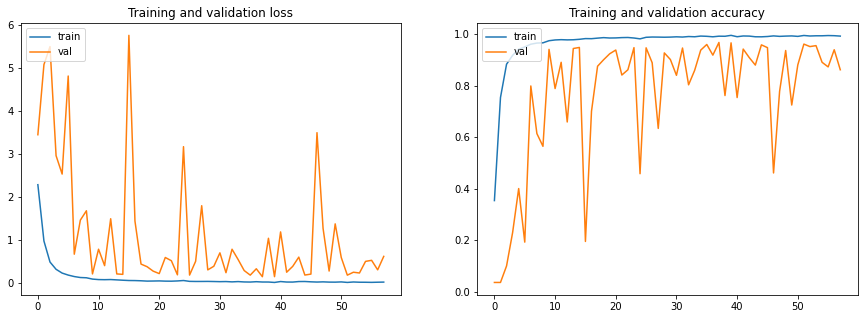

In [8]:
fig,ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title('Training and validation loss')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].set_title('Training and validation accuracy')
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

  Training set Accuracy = 99.2411%

  Training set Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       480
           2     1.0000    1.0000    1.0000       480
           3     0.9504    0.9979    0.9736       480
           4     1.0000    0.9729    0.9863       480
           5     1.0000    0.9896    0.9948       480
           6     0.9856    0.9979    0.9917       480
           7     1.0000    0.9875    0.9937       480
           8     0.9876    0.9979    0.9927       480
           9     0.9916    0.9854    0.9885       480
          10     0.9855    0.9938    0.9896       480
          11     0.9958    0.9833    0.9895       480
          12     0.9856    0.9958    0.9907       480
          13     0.9979    1.0000    0.9990       480
          14     0.9836    0.9979    0.9907       480
          15     0.9979    0.9854    0.9916       480
          16     0.9917    0.9979    0.9948       480
       

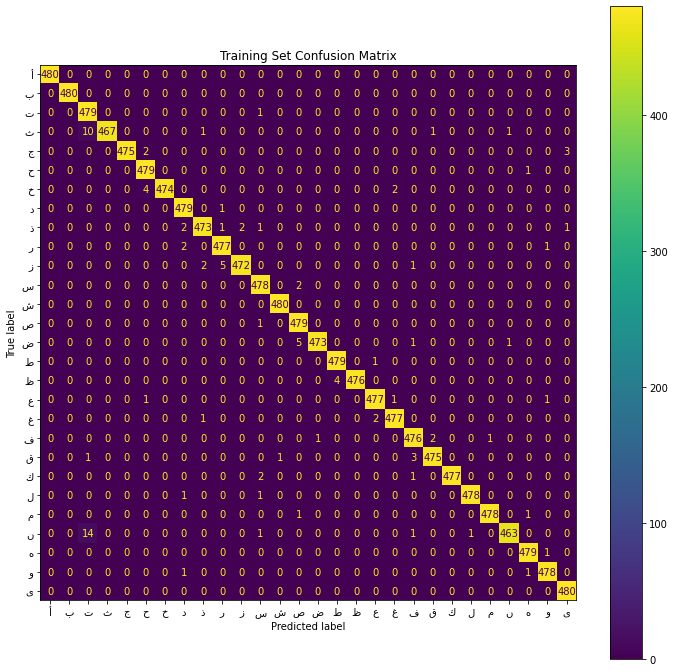

In [9]:
def estimate_model(model, X_train, y_train):
    y_pred = np.argmax(model.predict(X_train), axis=-1) + 1
    y_true = np.argmax(y_train, axis=-1) + 1
    
    labels=['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص',
            'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']
    
    print(f"  Training set Accuracy = {accuracy_score(y_true, y_pred):.4%}\n")
    print("  Training set Classification Report:")
    print(classification_report(y_true, y_pred, digits=4,))
    
    fig, ax = plt.subplots(figsize = (12, 12))
    ax.set_title("Training Set Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, values_format='d')

estimate_model(model, X_train, y_train) 

## **Test Set Prediction:**

In [10]:
y_preds = np.argmax(model.predict(test_im), axis=-1) + 1
test_labels['label'] = y_preds

In [11]:
test_labels

,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15
...,...,...
3355,3355,16
3356,3356,6
3357,3357,4
3358,3358,11


In [12]:
test_labels[['id', 'label']].to_csv('/kaggle/working/submission.csv', index=False)